(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic

# Import project package
import AutoEncode

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import ML libraries
import Flux

# Import library to save models
import JLD2

# Import basic math
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

# Exploratory data analysis of the RHVAE results

`[explanation here]`

Let's begin by listing the files with the saved model.

In [5]:
# List files in output directory
files = Glob.glob("output/model_state/*.jld2")

first(files, 5)

5-element Vector{String}:
 "output/model_state/rhvae_0.1temp_epoch00001.jld2"
 "output/model_state/rhvae_0.1temp_epoch00002.jld2"
 "output/model_state/rhvae_0.1temp_epoch00003.jld2"
 "output/model_state/rhvae_0.1temp_epoch00004.jld2"
 "output/model_state/rhvae_0.1temp_epoch00005.jld2"

Now, let's loop through each file, and load the values of the loss function and
the mean squared error for each model.

In [6]:
# Initialize empty dataframe
df_train = DF.DataFrame()
# Define fields to keep
fields = ["mse_train", "mse_val", "loss_train", "loss_val"]

# Loop through files
for f in files
    # spit file name to extract beta value and epoch number
    pars = split(f, "_")[end-1:end]
    # Parse beta value
    T = parse(Float64, replace(pars[1], "temp" => ""))
    # Parse epoch number
    epoch = parse(Int, replace(pars[2], ".jld2" => "", "epoch" => ""))
    # Load file and keep relevant fields
    file_load = JLD2.load(f)
    # Convert to dataframe
    df_tmp = DF.DataFrame(Dict(zip(fields, [file_load[x] for x in fields])))
    # Add beta and epoch to dataframe
    df_tmp[!, :T] .= T
    df_tmp[!, :epoch] .= epoch

    # Append to main dataframe
    DF.append!(df_train, df_tmp)
end # for

# Sort by beta and epoch
DF.sort!(df_train, [:T, :epoch])

first(df_train, 5)

Row,loss_train,loss_val,mse_train,mse_val,T,epoch
,Float32,Float32,Float32,Float32,Float64,Int64
1,10.1265,10.6833,0.985032,1.0549,0.1,1
2,10.2021,10.4646,0.961316,1.02864,0.1,2
3,9.93769,10.1137,0.84102,0.865036,0.1,3
4,9.87434,10.2487,0.767705,0.842494,0.1,4
5,9.9459,9.91688,0.790857,0.801246,0.1,5


With this information we can then plot the loss function and the mean squared
error for each model.

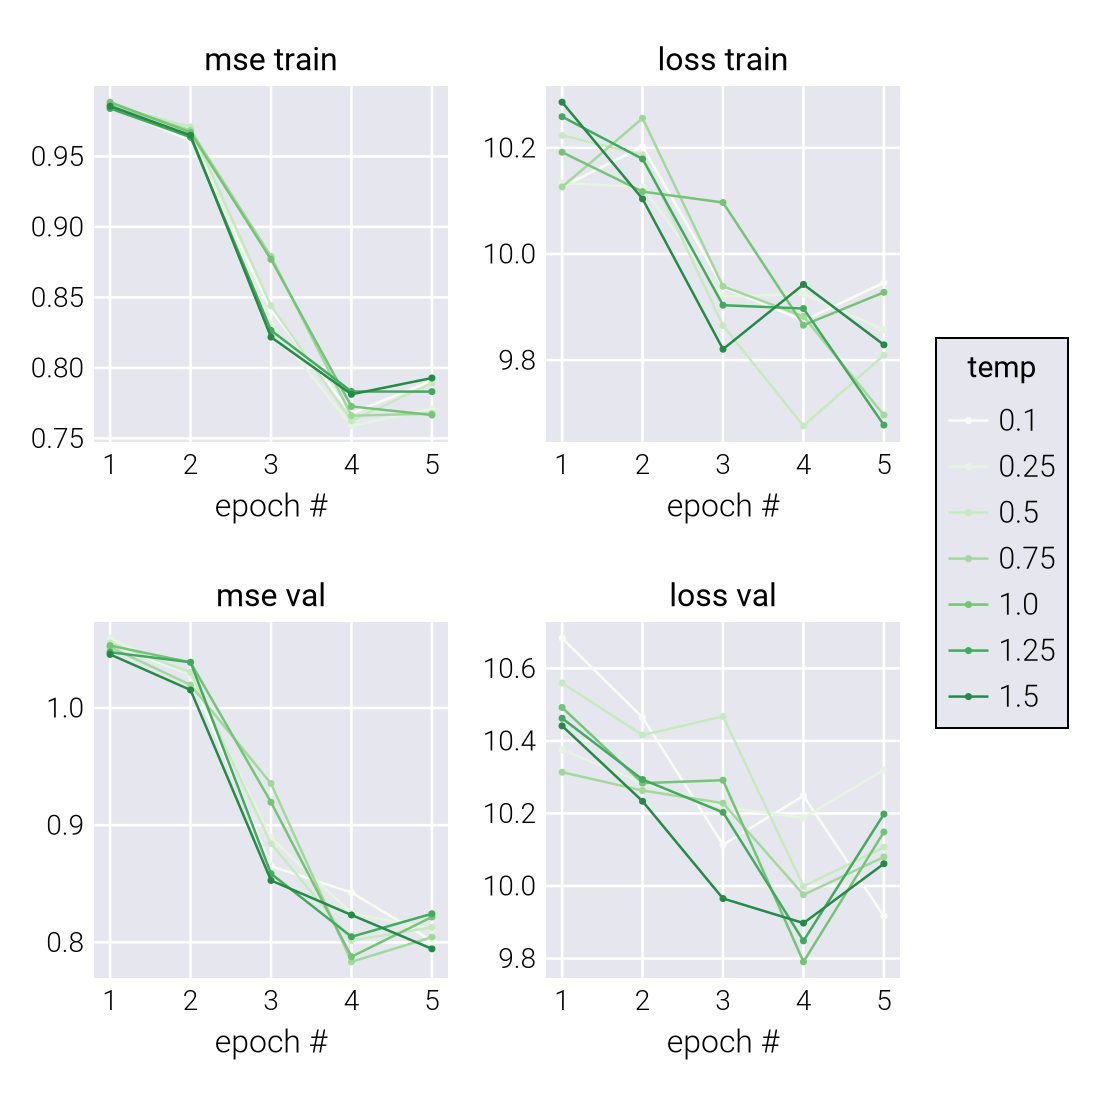

In [7]:
# Group data by β value
df_group = DF.groupby(df_train, :T)

# Initialize figure
fig = Figure(size=(550, 550))

# Add axes to figure
axes = [
    Axis(
        fig[i, j],
        aspect=AxisAspect(1),
        xlabel="epoch #",
    ) for i in 1:2, j in 1:2
]

# Loop through fields
for (i, field) in enumerate(fields)
    # Get axis
    ax = axes[i]
    # Loop through groups
    for (j, df) in enumerate(df_group)
        # Get x and y values
        x = df.epoch
        y = df[:, field]
        # Plot
        scatterlines!(
            ax, x, y, color=ColorSchemes.Greens[j], markersize=5,
            label="$(df.T[1])"
        )
    end # for
    # Set subplot title
    ax.title = replace(field, "_" => " ")
end # for

# Add legend to first subplot
Legend(fig[1:2, 3], axes[1], "temp", position=:rt)

fig